# Assignment: Measuring Cosmological Parameters Using Type Ia Supernovae

In this assignment, you'll analyze observational data from the Pantheon+SH0ES dataset of Type Ia supernovae to measure the Hubble constant $H_0$ and estimate the age of the universe. You will:

- Plot the Hubble diagram (distance modulus vs. redshift)
- Fit a cosmological model to derive $H_0$ and $\Omega_m$
- Estimate the age of the universe
- Analyze residuals to assess the model
- Explore the effect of fixing $\Omega_m$
- Compare low-z and high-z results

Let's get started!


## Getting Started: Setup and Libraries

Before we dive into the analysis, we need to import the necessary Python libraries:

- `numpy`, `pandas` — for numerical operations and data handling
- `matplotlib` — for plotting graphs
- `scipy.optimize.curve_fit` and `scipy.integrate.quad` — for fitting cosmological models and integrating equations
- `astropy.constants` and `astropy.units` — for physical constants and unit conversions

Make sure these libraries are installed in your environment. If not, you can install them using:

```bash
pip install numpy pandas matplotlib scipy astropy


##IMPORTING REQUIRED LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

## Load the Pantheon+SH0ES Dataset

We now load the observational supernova data from the Pantheon+SH0ES sample. This dataset includes calibrated distance moduli $\mu$, redshifts corrected for various effects, and uncertainties.

### Instructions:
- Make sure the data file is downloaded from [Pantheon dataset](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat) and available locally.
- We use `delim_whitespace=True` because the file is space-delimited rather than comma-separated.
- Commented rows (starting with `#`) are automatically skipped.

We will extract:
- `zHD`: Hubble diagram redshift
- `MU_SH0ES`: Distance modulus using SH0ES calibration
- `MU_SH0ES_ERR_DIAG`: Associated uncertainty


More detailed column names and the meanings can be referred here:

![image.png](attachment:image.png)

In [ ]:
# Local file path
file_path = "Pantheon+SH0ES.dat"

# Loading the file
file = pd.read_csv(file_path, delim_whitespace=True, comment="#")

# Seeing the structure
file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CID                   1701 non-null   object 
 1   IDSURVEY              1701 non-null   int64  
 2   zHD                   1701 non-null   float64
 3   zHDERR                1701 non-null   float64
 4   zCMB                  1701 non-null   float64
 5   zCMBERR               1701 non-null   float64
 6   zHEL                  1701 non-null   float64
 7   zHELERR               1701 non-null   float64
 8   m_b_corr              1701 non-null   float64
 9   m_b_corr_err_DIAG     1701 non-null   float64
 10  MU_SH0ES              1701 non-null   float64
 11  MU_SH0ES_ERR_DIAG     1701 non-null   float64
 12  CEPH_DIST             1701 non-null   float64
 13  IS_CALIBRATOR         1701 non-null   int64  
 14  USED_IN_SH0ES_HF      1701 non-null   int64  
 15  c                    

/tmp/ipython-input-4-2574597484.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  file = pd.read_csv(file_path, delim_whitespace=True, comment="#")


## Preview Dataset Columns

Before diving into the analysis, let’s take a quick look at the column names in the dataset. This helps us verify the data loaded correctly and identify the relevant columns we’ll use for cosmological modeling.


In [ ]:
for column in file.columns: #printing all columns in a neat way
    print(column)

CID
IDSURVEY
zHD
zHDERR
zCMB
zCMBERR
zHEL
zHELERR
m_b_corr
m_b_corr_err_DIAG
MU_SH0ES
MU_SH0ES_ERR_DIAG
CEPH_DIST
IS_CALIBRATOR
USED_IN_SH0ES_HF
c
cERR
x1
x1ERR
mB
mBERR
x0
x0ERR
COV_x1_c
COV_x1_x0
COV_c_x0
RA
DEC
HOST_RA
HOST_DEC
HOST_ANGSEP
VPEC
VPECERR
MWEBV
HOST_LOGMASS
HOST_LOGMASS_ERR
PKMJD
PKMJDERR
NDOF
FITCHI2
FITPROB
m_b_corr_err_RAW
m_b_corr_err_VPEC
biasCor_m_b
biasCorErr_m_b
biasCor_m_b_COVSCALE
biasCor_m_b_COVADD


## Clean and Extract Relevant Data

To ensure reliable fitting, we remove any rows that have missing values in key columns:

- `zHD`: redshift for the Hubble diagram  
- `MU_SH0ES`: distance modulus  
- `MU_SH0ES_ERR_DIAG`: uncertainty in the distance modulus  

We then extract these cleaned columns as NumPy arrays to prepare for analysis and modeling.


In [ ]:
# Filter for entries with usable data based on the required columns

#Cleaning the columns
file_clean = file.dropna(subset=['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG']) #rows with NA/missing values are dropped using dropna

#Extracting relevant data
Z = file_clean['zHD'].values
MU = file_clean['MU_SH0ES'].values
MU_ERR = file_clean['MU_SH0ES_ERR_DIAG'].values

In [ ]:
print(MU) #checking the values of MU AND MU_ERR
print(MU_ERR)

[28.9987 29.0559 30.7233 ... 45.4865 45.4233 46.1828]
[1.51645  1.51747  0.782372 ... 0.281981 0.358642 0.281309]


## Plot the Hubble Diagram

Let’s visualize the relationship between redshift $z$ and distance modulus $\mu$, known as the Hubble diagram. This plot is a cornerstone of observational cosmology—it allows us to compare supernova observations with theoretical predictions based on different cosmological models.

We use a logarithmic scale on the redshift axis to clearly display both nearby and distant supernovae.


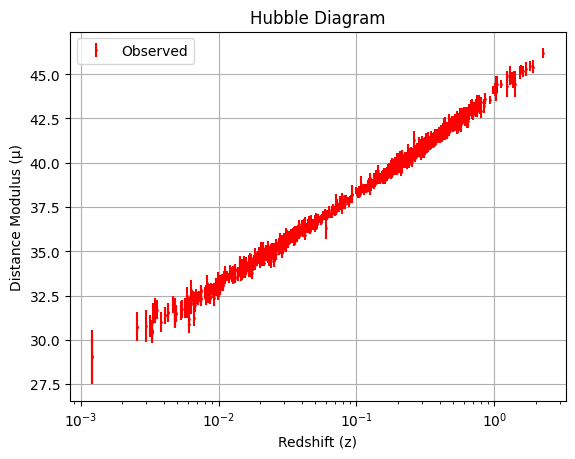

In [ ]:
#Errorbar plot
#errorbar is plotted to show the uncertainity in the data points


import matplotlib.pyplot as plt
plt.errorbar(Z, MU, yerr=MU_ERR, fmt='o', markersize=1,color='red',label='Observed') #yerr is vertical bar to check to show distance modulus uncertainity
#fmt and markersize are used to make the graph better. points in the graph are marked with o of size=3
plt.xscale('log') #sets the scale of x-axis to log for better graph visuals
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (μ)")
plt.title("Hubble Diagram")
plt.legend() #helps show the label
plt.grid(True)
plt.show()


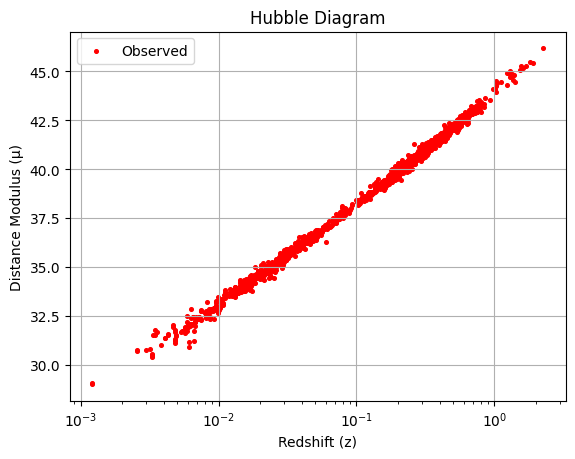

In [ ]:
 #Scatter plot without MU_ERR

import matplotlib.pyplot as plt
plt.scatter(Z, MU,color='red',s=7,label='Observed')
plt.xscale('log') #sets the scale of x-axis to log for better graph visuals
plt.xlabel("Redshift (z)")
plt.ylabel("Distance Modulus (μ)")
plt.title("Hubble Diagram")
plt.grid(True)
plt.legend()
plt.show()


## Define the Cosmological Model

We now define the theoretical framework based on the flat $\Lambda\mathrm{CDM}$ model (read about the model in wikipedia if needed). This involves:

- The dimensionless Hubble parameter:
  $$
  E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
  $$

- The distance modulus is:
  $$
  \mu(z) = 5 \log_{10}(d_L / \text{Mpc}) + 25
  $$

- And the corresponding luminosity distance :
  
  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

These equations allow us to compute the expected distance modulus from a given redshift $z$, Hubble constant $H_0$, and matter density parameter $\Omega_m$.


In [ ]:
# Speed of light in km/s
c = 299792.458
from scipy.integrate import quad
# Define the E(z) for flat LCDM
# ΛCDM means lambda cold dark matter and is a math model of the big bang theory. Λ-cosmological constant due to dark energy. CDM-cold dark matter
def E(z, Omega_m):
  return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# Luminosity distance in Mpc, scipy quad was used to integrate.
def luminosity_distance(z, H0, Omega_m):
  integral = np.array([quad(lambda z_: 1.0 / E(z_, Omega_m), 0, z_i)[0] for z_i in z])
  dL = (c / H0) * (1 + z) * integral
  return dL

# Theoretical distance modulus, use above function inside mu_theory to compute luminosity distance
def mu_theory(z, H0, Omega_m):
  dL = luminosity_distance(z, H0, Omega_m)
  return 5 * np.log10(dL) + 25

## Fit the Model to Supernova Data

We now perform a non-linear least squares fit to the supernova data using our theoretical model for $\mu(z)$. This fitting procedure will estimate the best-fit values for the Hubble constant $ H_0$ and matter density parameter $\Omega_m$, along with their associated uncertainties.

We'll use:
- `curve_fit` from `scipy.optimize` for the fitting.
- The observed distance modulus \(\mu\), redshift \(z\), and measurement errors.

The initial guess is:
- $ H_0 = 70 \, \text{km/s/Mpc} $
- $\Omega_m =0.3$


In [ ]:
from scipy.optimize import curve_fit

def fit_func(z, H0, Omega_m):
    return mu_theory(z, H0, Omega_m)

# Initial guess: H0 = 70, Omega_m = 0.3
p0 = [70, 0.3]

# Write a code for fitting and taking error out of the parameters
params, cov = curve_fit(fit_func, Z, MU, sigma=MU_ERR, p0=p0)#performing fitting

#extracting the fitted values and uncertainities
H0_fit, Omega_m_fit = params
H0_err, Omega_m_err = np.sqrt(np.diag(cov))

print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")


Fitted H0 = 72.97 ± 0.17 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.012


## Estimate the Age of the Universe

Now that we have the best-fit values of $ H_0 $ and $ \Omega_m $, we can estimate the age of the universe. This is done by integrating the inverse of the Hubble parameter over redshift:

$$
t_0 = \int_0^\infty \frac{1}{(1 + z) H(z)} \, dz
$$

We convert $ H_0 $ to SI units and express the result in gigayears (Gyr). This provides an independent check on our cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.


In [ ]:
from scipy.integrate import quad
import astropy.units as u
import numpy as np

def age_of_universe(H0, Omega_m):
    H0_SI = (H0 * u.km / u.s / u.Mpc).to(1 / u.s).value  # Converting H0 from km/s/Mpc to 1/s

    #Integrating from z=0 to infinity
    integrand = lambda z: 1.0 / ((1 + z) * np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m)))
    integral, _ = quad(integrand, 0, np.inf)

    t0_seconds = integral / H0_SI #Age in seconds
    t0_gyr = (t0_seconds * u.s).to(u.Gyr).value  # Converting from seconds to GYR

    return t0_gyr

# Calling the age_of_universe function with the best fit paramenters:
t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")

Estimated age of Universe: 12.36 Gyr


## Analyze Residuals

To evaluate how well our cosmological model fits the data, we compute the residuals:

$$
\text{Residual} = \mu_{\text{obs}} - \mu_{\text{model}}
$$

Plotting these residuals against redshift helps identify any systematic trends, biases, or outliers. A good model fit should show residuals scattered randomly around zero without any significant structure.


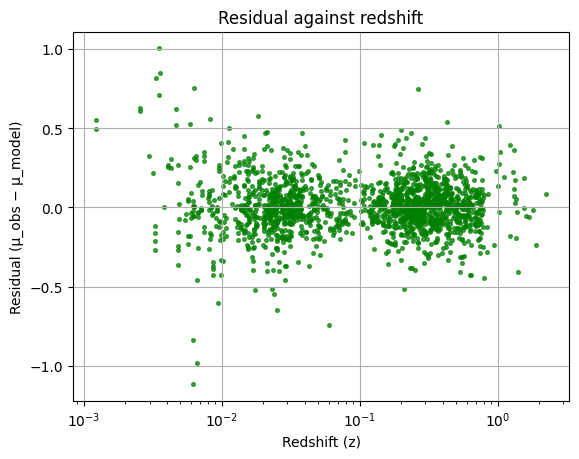

In [ ]:
# Write the code to find residual by computing mu_theory and then plot
mu_model = fit_func(Z, H0_fit, Omega_m_fit)
residuals = MU - mu_model

#PLOT
plt.scatter(Z, residuals, s=7, color='green', alpha=0.7) #alpha is for transparency
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Residual (μ_obs − μ_model)')
plt.title('Residual against redshift')
plt.grid(True)
plt.show()

## Fit with Fixed Matter Density

To reduce parameter degeneracy, let's fix $ \Omega_m = 0.3 $ and fit only for the Hubble constant $ H_0 $.


In [ ]:
from scipy.optimize import curve_fit
import numpy as np

# Function with fixed Omega_m
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

# Initial guess for H0
p0 = [70]

# Perform the fit (only H0 is varied)
params_fixed, cov_fixed = curve_fit(mu_fixed_Om, Z, MU, sigma=MU_ERR, p0=p0, absolute_sigma=True)

# Extract fitted H0 and its uncertainty
H0_fixed = params_fixed[0]
H0_fixed_err = np.sqrt(cov_fixed[0, 0])

print(f"Fitted H0 with Ωm=0.3: {H0_fixed:.2f} ± {H0_fixed_err:.2f} km/s/Mpc")


Fitted H0 with Ωm=0.3: 73.53 ± 0.17 km/s/Mpc


## Compare Low-z and High-z Subsamples

Finally, we examine whether the inferred value of $H_0$ changes with redshift by splitting the dataset into:
- **Low-z** supernovae ($ z < 0.1 $)
- **High-z** supernovae ($ z \geq 0.1 $)

We then fit each subset separately (keeping $ \Omega_m = 0.3 $) to explore any potential tension or trend with redshift.


In [ ]:
from scipy.optimize import curve_fit

# Split point
z_split = 0.1

# Redshift and distance modulus data are extracted
Z = file_clean['zHD'].values
MU = file_clean['MU_SH0ES'].values
MU_ERR = file_clean['MU_SH0ES_ERR_DIAG'].values

# Low-z supernovae (z < 0.1)
mask_low = Z < z_split
Z_low = Z[mask_low]
MU_low = MU[mask_low]
MU_ERR_low = MU_ERR[mask_low]

# High-z supernovae (z >= 0.1)
mask_high = Z >= z_split
Z_high = Z[mask_high]
MU_high = MU[mask_high]
MU_ERR_high = MU_ERR[mask_high]

# Fit only H0 with fixed Ωm = 0.3
p0 = [70]  # Initial guess for H0

# Performing curve fitting
H0_low, _ = curve_fit(mu_fixed_Om, Z_low, MU_low, sigma=MU_ERR_low, p0=p0, absolute_sigma=True)
H0_high, _ = curve_fit(mu_fixed_Om, Z_high, MU_high, sigma=MU_ERR_high, p0=p0, absolute_sigma=True)

# Print results
print(f"Low-z (z < {z_split}): H₀ = {H0_low[0]:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H₀ = {H0_high[0]:.2f} km/s/Mpc")


Low-z (z < 0.1): H₀ = 73.01 km/s/Mpc
High-z (z ≥ 0.1): H₀ = 73.85 km/s/Mpc


You can check your results and potential reasons for different values from accepted constant using this paper by authors of the [Pantheon+ dataset](https://arxiv.org/pdf/2310.11727)

You can find more about the dataset in the paper too